In [72]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings("ignore")

hospital = pd.read_csv("Preprocessed ICU data.csv")
hospital.set_index("RecordID", inplace = True)
hospital.head()

,Age,Gender,Height,ICUType2,ICUType3,ICUType4,Mean_Weight.x,Mean_GCS.x,Mean_HR.x,Mean_NIDiasABP.x,...,Max_ALT.y,Max_AST.y,Max_Bilirubin.y,Max_Lactate.y,Max_Cholesterol.y,Max_TroponinI.y,Max_TroponinT.y,SAPS.I,SOFA,In.hospital_death
RecordID,,,,,,,,,,,,,,,,,,,,,
132543,68,1.0,180.300000,0,1,0,84.600000,14.888889,72.971429,65.970588,...,12.000000,15.000000,0.200000,2.395461,156.842105,7.132683,1.114629,7,1,0
132545,88,0.0,169.787227,0,1,0,83.054136,15.000000,79.520000,49.333333,...,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629,17,2,0
132547,64,1.0,180.300000,0,0,0,114.000000,8.333333,81.318182,70.500000,...,60.000000,162.000000,0.400000,2.395461,212.000000,1.300000,1.114629,14,11,0
132551,78,0.0,162.600000,0,1,0,48.400000,13.250000,78.125000,28.000000,...,46.000000,82.000000,0.300000,2.300000,156.842105,3.500000,1.114629,19,8,1
132554,64,0.0,169.787227,0,1,0,60.700000,15.000000,129.363636,65.454545,...,189.169186,260.323666,1.979557,2.395461,156.842105,7.132683,1.114629,11,0,0


## EDA

In [73]:
hospital.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1474 entries, 132543 to 142671
Columns: 231 entries, Age to In.hospital_death
dtypes: float64(217), int64(14)
memory usage: 2.6 MB


<Axes: xlabel='In.hospital_death', ylabel='count'>

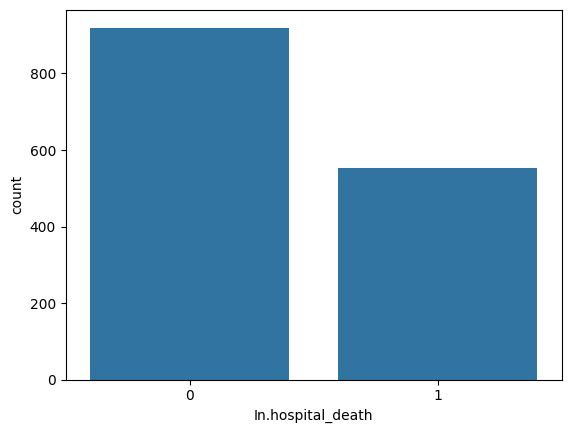

In [74]:
#Compare the number of death and survive number 
hospital['In.hospital_death'].value_counts(normalize=True)
sns.countplot(x='In.hospital_death', data=hospital)


Num of stays: 1474
count    1474.000000
mean       70.852782
std        14.691788
min        19.000000
25%        61.000000
50%        74.000000
75%        83.000000
max        90.000000
Name: Age, dtype: float64


<Axes: xlabel='Age', ylabel='Count'>

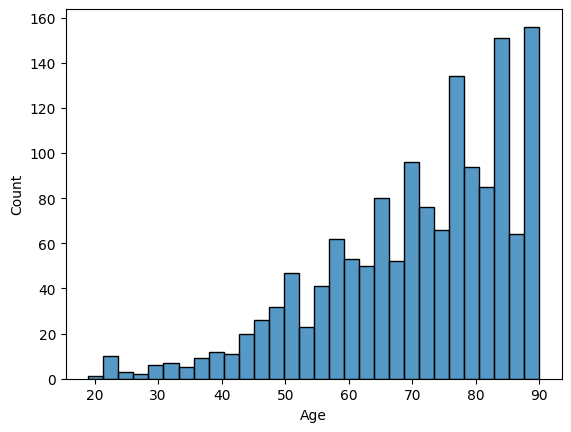

In [75]:
#sample size
print("Num of stays:", hospital.shape[0])


# age distribution 
print(hospital['Age'].describe())
sns.histplot(hospital['Age'], bins=30)

In [76]:
# Gender shows label other than 0,1 thus filtering out the other number 
# retain the row of Gender == 0 or Gender == 1 
hospital = hospital[hospital['Gender'].isin([0,1])]

# genger proportion
print("Gender proportion:",hospital['Gender'].value_counts(normalize=True))


print(hospital['In.hospital_death'].value_counts(normalize=True))

Gender proportion: Gender
1.0    0.540761
0.0    0.459239
Name: proportion, dtype: float64
In.hospital_death
0    0.624321
1    0.375679
Name: proportion, dtype: float64


count    1472.000000
mean      169.228496
std        12.716421
min        13.700000
25%       169.787227
50%       169.787227
75%       169.787227
max       419.100000
Name: Height, dtype: float64
0
4


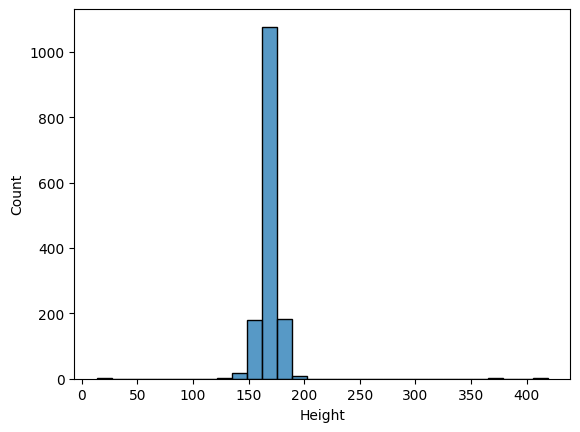

In [77]:
print(hospital['Height'].describe())
sns.histplot(hospital['Height'], bins=30)
print(hospital["Height"].isnull().sum())
hospital['Height_abnormal'] = ((hospital['Height'] < 120) | (hospital['Height'] > 200)).astype(int)
print(hospital['Height_abnormal'] .sum())
# found that there exists extreme value


count    1472.000000
mean      169.135249
std         7.772634
min       132.100000
25%       169.787227
50%       169.787227
75%       169.787227
max       198.100000
Name: Height, dtype: float64


<Axes: xlabel='Height', ylabel='Count'>

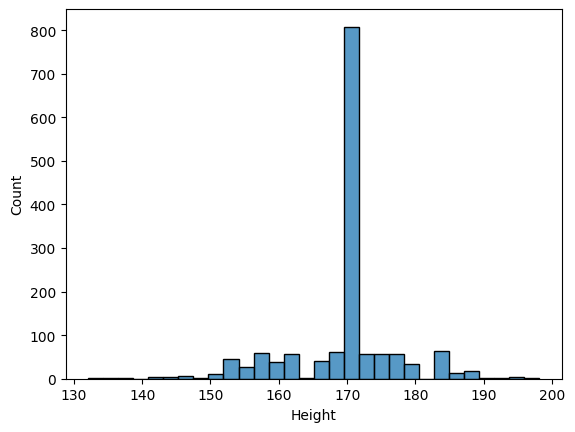

In [78]:
mean_height = hospital.loc[hospital['Height_abnormal'] == 0, 'Height'].mean()
hospital.loc[hospital['Height_abnormal'] == 1, 'Height'] = mean_height
print(hospital['Height'].describe())
sns.histplot(hospital['Height'], bins=30)


count    1472.000000
mean       80.226738
std        23.967588
min         2.187500
25%        64.849596
50%        78.550000
75%        90.000000
max       230.000000
Name: Mean_Weight.x, dtype: float64

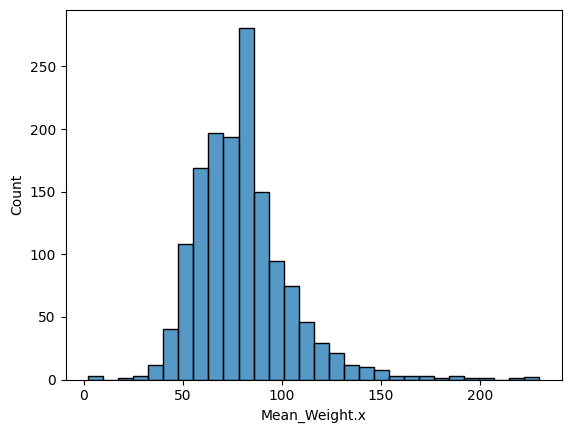

In [79]:
sns.histplot(hospital['Mean_Weight.x'], bins=30)
hospital['Mean_Weight.x'].describe()


In [80]:
mask = (hospital['Mean_Weight.x'] < 20) | (hospital['Mean_Weight.x'] > 200) #bool value
mean_weight = hospital.loc[~mask, 'Mean_Weight.x'].mean()
hospital.loc[mask, 'Mean_Weight.x'] = mean_weight
hospital['Mean_Weight.x'].describe()

count    1472.000000
mean       80.087246
std        22.808168
min        23.594444
25%        65.000000
50%        78.712500
75%        90.000000
max       199.744444
Name: Mean_Weight.x, dtype: float64

Text(0.5, 1.0, 'Distribution of ICU Types')

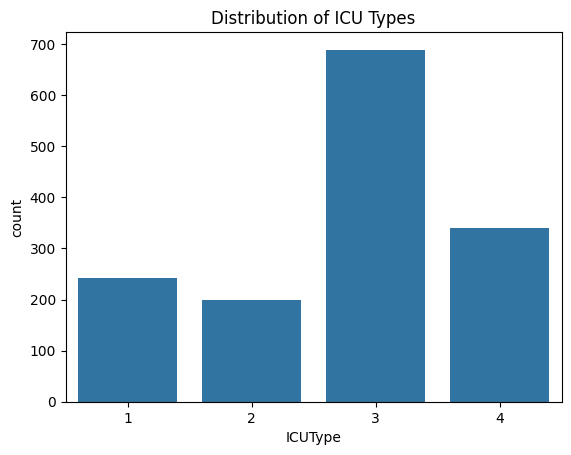

In [81]:
def combine_icutype(row):
    if row['ICUType2'] == 1:
        return 2
    elif row['ICUType3'] == 1:
        return 3
    elif row['ICUType4'] == 1:
        return 4
    else:
        return 1   # all zero → ICU Type 1

hospital['ICUType'] = hospital.apply(combine_icutype, axis=1)
sns.countplot(x='ICUType', data=hospital)
plt.title("Distribution of ICU Types")



Text(0, 0.5, 'Mortality Rate')

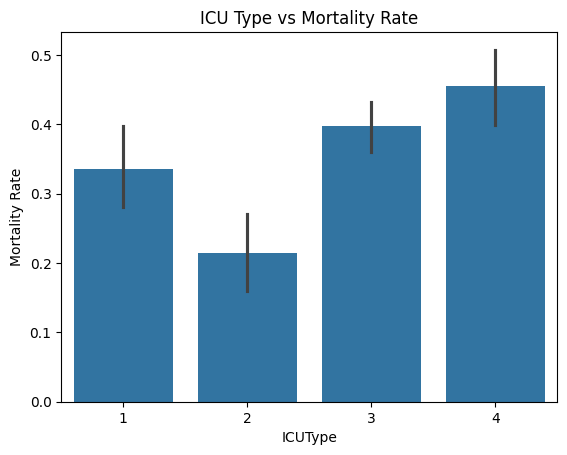

In [82]:
sns.barplot(x='ICUType', y='In.hospital_death', data=hospital)
plt.title("ICU Type vs Mortality Rate")
plt.ylabel("Mortality Rate")


In [83]:
hospital.head()

,Age,Gender,Height,ICUType2,ICUType3,ICUType4,Mean_Weight.x,Mean_GCS.x,Mean_HR.x,Mean_NIDiasABP.x,...,Max_Bilirubin.y,Max_Lactate.y,Max_Cholesterol.y,Max_TroponinI.y,Max_TroponinT.y,SAPS.I,SOFA,In.hospital_death,Height_abnormal,ICUType
RecordID,,,,,,,,,,,,,,,,,,,,,
132543,68,1.0,180.300000,0,1,0,84.600000,14.888889,72.971429,65.970588,...,0.200000,2.395461,156.842105,7.132683,1.114629,7,1,0,0,3
132545,88,0.0,169.787227,0,1,0,83.054136,15.000000,79.520000,49.333333,...,1.979557,2.395461,156.842105,7.132683,1.114629,17,2,0,0,3
132547,64,1.0,180.300000,0,0,0,114.000000,8.333333,81.318182,70.500000,...,0.400000,2.395461,212.000000,1.300000,1.114629,14,11,0,0,1
132551,78,0.0,162.600000,0,1,0,48.400000,13.250000,78.125000,28.000000,...,0.300000,2.300000,156.842105,3.500000,1.114629,19,8,1,0,3
132554,64,0.0,169.787227,0,1,0,60.700000,15.000000,129.363636,65.454545,...,1.979557,2.395461,156.842105,7.132683,1.114629,11,0,0,0,3


In [84]:
missing = hospital.isna().mean().sort_values(ascending=False)
missing.head(20)

Age                   0.0
Min_RespRate.y        0.0
Mean_AST.y            0.0
Mean_Bilirubin.y      0.0
Mean_Lactate.y        0.0
Mean_Cholesterol.y    0.0
Mean_TroponinI.y      0.0
Mean_TroponinT.y      0.0
Min_Weight.y          0.0
Min_GCS.y             0.0
Min_HR.y              0.0
Min_NIDiasABP.y       0.0
Min_NIMAP.y           0.0
Min_NISysABP.y        0.0
Min_Temp.y            0.0
Mean_Weight.y         0.0
Min_Urine.y           0.0
Min_BUN.y             0.0
Min_Creatinine.y      0.0
Min_Glucose.y         0.0
dtype: float64

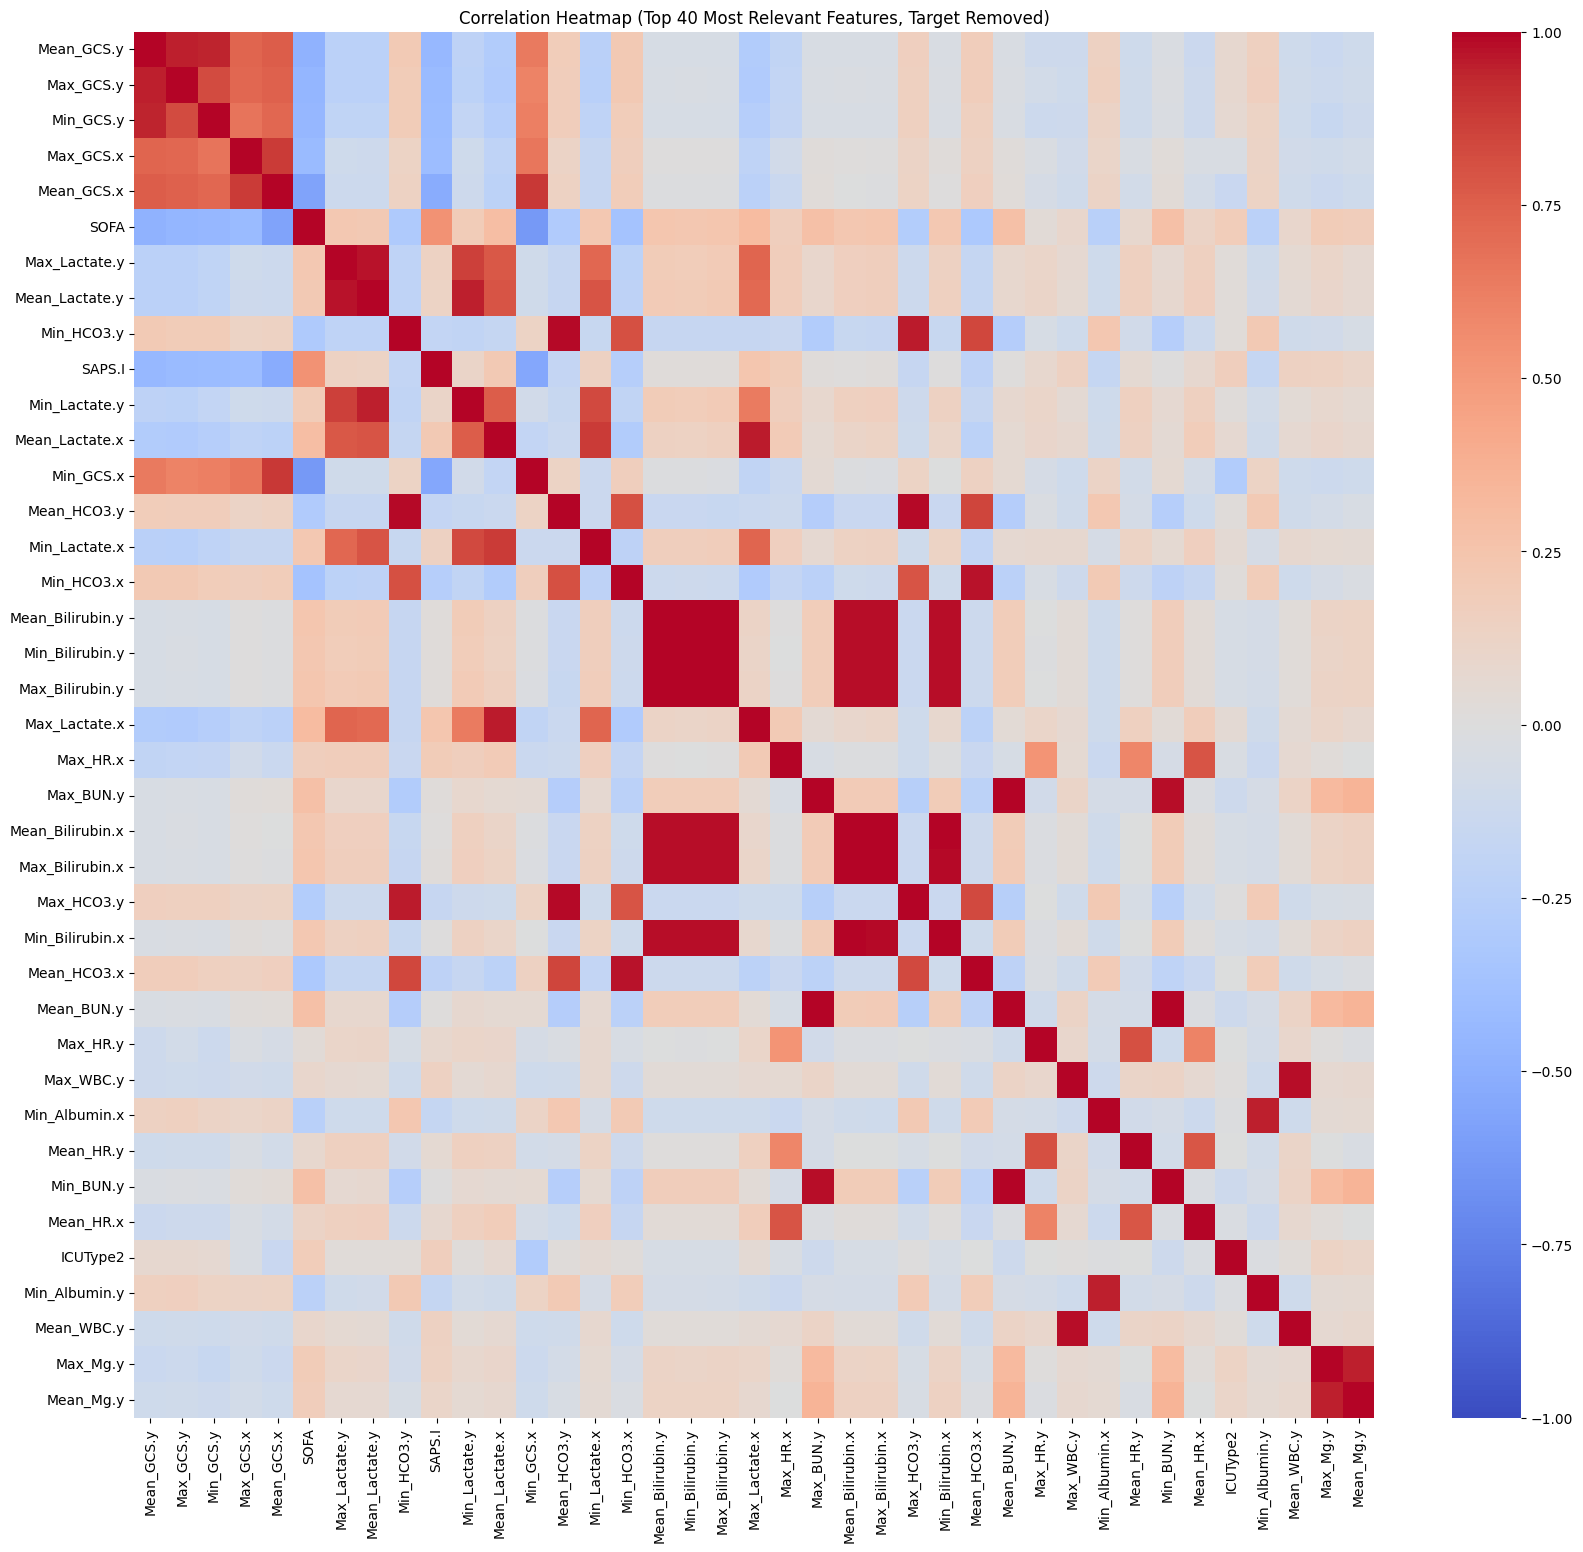

Index(['In.hospital_death', 'Mean_GCS.y', 'Max_GCS.y', 'Min_GCS.y',
       'Max_GCS.x', 'Mean_GCS.x', 'SOFA', 'Max_Lactate.y', 'Mean_Lactate.y',
       'Min_HCO3.y', 'SAPS.I', 'Min_Lactate.y', 'Mean_Lactate.x', 'Min_GCS.x',
       'Mean_HCO3.y', 'Min_Lactate.x', 'Min_HCO3.x', 'Mean_Bilirubin.y',
       'Min_Bilirubin.y', 'Max_Bilirubin.y', 'Max_Lactate.x', 'Max_HR.x',
       'Max_BUN.y', 'Mean_Bilirubin.x', 'Max_Bilirubin.x', 'Max_HCO3.y',
       'Min_Bilirubin.x', 'Mean_HCO3.x', 'Mean_BUN.y', 'Max_HR.y', 'Max_WBC.y',
       'Min_Albumin.x', 'Mean_HR.y', 'Min_BUN.y', 'Mean_HR.x', 'ICUType2',
       'Min_Albumin.y', 'Mean_WBC.y', 'Max_Mg.y', 'Mean_Mg.y'],
      dtype='object')

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = hospital.select_dtypes(include=['float', 'int']).columns

# calcualte the correlation matrix
corr = hospital[num_cols].corr()

# top 40 most relevant vairables 
top_corr = corr['In.hospital_death'].abs().sort_values(ascending=False).head(40).index

top_corr_no_target = [col for col in top_corr if col != 'In.hospital_death']

plt.figure(figsize=(20,18))
sns.heatmap(hospital[top_corr_no_target].corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap (Top 40 Most Relevant Features, Target Removed)")
plt.show()
top_corr

In [86]:
import numpy as np

# Select only numeric columns
num_cols = hospital.select_dtypes(include=['float', 'int']).columns

# Compute the absolute correlation matrix
corr_matrix = hospital[num_cols].corr().abs()

# Look at the upper triangle to avoid duplicate comparisons
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns with correlations above 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

print("Highly correlated features to drop (>0.90):")
print(to_drop)

# Drop the highly correlated columns
hospital_filtered = hospital.drop(columns=to_drop)

print("\nFinal number of features after removing multicollinearity:", len(hospital_filtered.columns))
print(hospital_filtered.columns)


Highly correlated features to drop (>0.90):
['Min_Weight.x', 'Min_BUN.x', 'Min_Creatinine.x', 'Min_HCO3.x', 'Min_GCT.x', 'Min_Platelets.x', 'Min_Na.x', 'Min_WBC.x', 'Min_PaCO2.x', 'Min_Albumin.x', 'Min_ALP.x', 'Min_ALT.x', 'Min_AST.x', 'Min_Bilirubin.x', 'Min_Cholesterol.x', 'Min_TroponinI.x', 'Min_TroponinT.x', 'Max_Weight.x', 'Max_BUN.x', 'Max_Creatinine.x', 'Max_HCO3.x', 'Max_GCT.x', 'Max_Mg.x', 'Max_Platelets.x', 'Max_Na.x', 'Max_WBC.x', 'Max_pH.x', 'Max_SaO2.x', 'Max_Albumax.x', 'Max_ALP.x', 'Max_ALT.x', 'Max_AST.x', 'Max_Bilirubin.x', 'Max_Lactate.x', 'Max_Cholesterol.x', 'Max_TroponinI.x', 'Max_TroponinT.x', 'Mean_Weight.y', 'Mean_BUN.y', 'Mean_Creatinine.y', 'Mean_Platelets.y', 'Mean_SaO2.y', 'Mean_Albumin.y', 'Mean_ALP.y', 'Mean_Bilirubin.y', 'Mean_Cholesterol.y', 'Mean_TroponinI.y', 'Mean_TroponinT.y', 'Min_Weight.y', 'Min_GCS.y', 'Min_BUN.y', 'Min_Creatinine.y', 'Min_HCO3.y', 'Min_GCT.y', 'Min_Mg.y', 'Min_Platelets.y', 'Min_K.y', 'Min_Na.y', 'Min_WBC.y', 'Min_PaCO2.y', 'Min_

## model building 
### with fitered feature

In [87]:
#building model with filtered features (remove high-correlated features to reduce multicollinearity and simplify the dataset.)
from sklearn.model_selection import train_test_split


X = hospital_filtered.drop(columns=['In.hospital_death'])
y = hospital_filtered['In.hospital_death']

#Even after removing highly correlated features, we need to drop constant or nearly constant columns 
#because they carry little to no information and can negatively affect model performance.
constant_cols = [col for col in X.columns if X[col].nunique() == 1]
quasi_constant_cols = []
for col in X.columns:
    top_freq = X[col].value_counts(normalize=True).iloc[0]
    if top_freq > 0.95:
        quasi_constant_cols.append(col)

cols_to_remove = list(set(constant_cols + quasi_constant_cols))
print("Remove:", cols_to_remove)

#drop these columns
X = X.drop(columns=cols_to_remove)

# train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



Remove: ['Height_abnormal', 'Max_MechVent.y', 'Min_MechVent.y', 'Max_MechVent.x', 'Min_MechVent.x', 'Mean_MechVent.y', 'Mean_MechVent.x']


In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))


cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred, digits=3))


Accuracy: 0.735593220338983
AUC: 0.7918869956913435
[[163  21]
 [ 57  54]]
              precision    recall  f1-score   support

           0      0.741     0.886     0.807       184
           1      0.720     0.486     0.581       111

    accuracy                          0.736       295
   macro avg      0.730     0.686     0.694       295
weighted avg      0.733     0.736     0.722       295



AUC measures the model’s ability to distinguish between positive cases (death) and negative cases (survival).
A relatively high AUC (e.g., 0.78–0.80) indicates that:

1）Patients who died tend to receive higher predicted probabilities (risk scores)

2）Patients who survived tend to receive lower predicted probabilities

3）Regardless of the threshold chosen, the model still has strong ranking ability.
so model more tend to predict the result of death in this case.



## try gridsearch, change the parameter to see improve or not

In [89]:

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [None, 10, 20, 40],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced'
)

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best AUC:", grid.best_score_)
print("Best params:", grid.best_params_)






Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best AUC: 0.7599785981808455
Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 600}


In [90]:
best_rf = grid.best_estimator_

best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test AUC:", roc_auc_score(y_test, y_proba))


cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred, digits=3))


Test Accuracy: 0.7423728813559322
Test AUC: 0.7947512730121424
[[156  28]
 [ 48  63]]
              precision    recall  f1-score   support

           0      0.765     0.848     0.804       184
           1      0.692     0.568     0.624       111

    accuracy                          0.742       295
   macro avg      0.729     0.708     0.714       295
weighted avg      0.737     0.742     0.736       295



### try xgboost model

In [91]:
#xg boost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [92]:
# baseline XGBoost

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]  # 取正类概率


print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("Baseline AUC:", roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred, digits=3))

Baseline Accuracy: 0.7084745762711865
Baseline AUC: 0.7716412064238152
[[148  36]
 [ 50  61]]
              precision    recall  f1-score   support

           0      0.747     0.804     0.775       184
           1      0.629     0.550     0.587       111

    accuracy                          0.708       295
   macro avg      0.688     0.677     0.681       295
weighted avg      0.703     0.708     0.704       295



In [93]:
param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best CV AUC:", grid.best_score_)
print("Best Params:", grid.best_params_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best CV AUC: 0.7687172110928131
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}


In [94]:
best_xgb = grid.best_estimator_

y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test AUC:", roc_auc_score(y_test, y_proba))
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred, digits=3))


Test Accuracy: 0.7152542372881356
Test AUC: 0.7691931061496279
[[151  33]
 [ 51  60]]
              precision    recall  f1-score   support

           0      0.748     0.821     0.782       184
           1      0.645     0.541     0.588       111

    accuracy                          0.715       295
   macro avg      0.696     0.681     0.685       295
weighted avg      0.709     0.715     0.709       295



### SMOTE for improvement 

In [95]:
#SMOTE for improving models to identify and predict the death case

from imblearn.over_sampling import SMOTE


#  SMOTE on training dataset 
sm = SMOTE(random_state=42, k_neighbors=5)  # k_neighbors 默认 5，一般可以先用默认
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE:", y_train_res.value_counts())

# Random Forest(with SMOTE training dataset)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight='balanced'   
)

rf.fit(X_train_res, y_train_res)


y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred, digits=3))


After SMOTE: In.hospital_death
0    735
1    735
Name: count, dtype: int64
Accuracy: 0.7491525423728813
AUC: 0.7855219349784568
[[145  39]
 [ 35  76]]
              precision    recall  f1-score   support

           0      0.806     0.788     0.797       184
           1      0.661     0.685     0.673       111

    accuracy                          0.749       295
   macro avg      0.733     0.736     0.735       295
weighted avg      0.751     0.749     0.750       295



### After applying SMOTE, the model’s recall and F1 for the minority class (death) improved significantly, making it better at identifying high-risk patients.

In [104]:
num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()

scale_pos_weight = num_neg / num_pos
print("scale_pos_weight =", scale_pos_weight)


scale_pos_weight = 1.66289592760181


In [105]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# calculate the weight
num_neg = (y_train == 0).sum()  
num_pos = (y_train == 1).sum()  

scale_pos_weight = num_neg / num_pos
print("scale_pos_weight =", scale_pos_weight)

# adding weight to the model
xgb_weighted = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  
    random_state=42
)


xgb_weighted.fit(X_train, y_train)


y_pred = xgb_weighted.predict(X_test)
y_proba = xgb_weighted.predict_proba(X_test)[:, 1]


print("Weighted XGB Accuracy:", accuracy_score(y_test, y_pred))
print("Weighted XGB AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


scale_pos_weight = 1.66289592760181
Weighted XGB Accuracy: 0.7084745762711865
Weighted XGB AUC: 0.7634645515080297
[[142  42]
 [ 44  67]]
              precision    recall  f1-score   support

           0      0.763     0.772     0.768       184
           1      0.615     0.604     0.609       111

    accuracy                          0.708       295
   macro avg      0.689     0.688     0.688       295
weighted avg      0.707     0.708     0.708       295



### change the threshold in a range to find the best performance

In [108]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.15,      # 15% as test set
    stratify=y,
    random_state=42
)

# Step 2: Split temp into train (70%) and validation (15%)
val_size = 0.15 / 0.85  # fraction within temp to get 15% total
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=val_size,
    stratify=y_temp,
    random_state=42
)


In [110]:
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred = xgb_weighted.predict(X_test)
y_proba = xgb_weighted.predict_proba(X_test)[:, 1]


In [111]:
#  Predict probabilities on validation set
probs_val = xgb.predict_proba(X_val)[:, 1]

#  Tune threshold based on F1-score
thresholds = np.arange(0.1, 0.9, 0.02)
best_f1 = 0
best_threshold = 0.5

for t in thresholds:
    preds = (probs_val >= t).astype(int)
    f1 = f1_score(y_val, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best threshold: {best_threshold}, Best F1: {best_f1:.3f}")

# Step 6: Final predictions on validation set with best threshold
best_preds_val = (probs_val >= best_threshold).astype(int)

print("\nValidation Metrics:")
print("Confusion Matrix:\n", confusion_matrix(y_val, best_preds_val))
print(classification_report(y_val, best_preds_val, digits=3))
print(f"Precision: {precision_score(y_val, best_preds_val):.3f}, "
      f"Recall: {recall_score(y_val, best_preds_val):.3f}, "
      f"F1-score: {f1_score(y_val, best_preds_val):.3f}, "
      f"AUC: {roc_auc_score(y_val, probs_val):.3f}")

Best threshold: 0.12000000000000001, Best F1: 0.626

Validation Metrics:
Confusion Matrix:
 [[74 64]
 [16 67]]
              precision    recall  f1-score   support

           0      0.822     0.536     0.649       138
           1      0.511     0.807     0.626        83

    accuracy                          0.638       221
   macro avg      0.667     0.672     0.638       221
weighted avg      0.706     0.638     0.641       221

Precision: 0.511, Recall: 0.807, F1-score: 0.626, AUC: 0.737


In [112]:
#  Evaluate on final test set using the same threshold
probs_test = xgb.predict_proba(X_test)[:, 1]
y_pred_test = (probs_test >= best_threshold).astype(int)

print("\nTest Metrics:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test, digits=3))
print(f"Precision: {precision_score(y_test, y_pred_test):.3f}, "
      f"Recall: {recall_score(y_test, y_pred_test):.3f}, "
      f"F1-score: {f1_score(y_test, y_pred_test):.3f}, "
      f"AUC: {roc_auc_score(y_test, probs_test):.3f}")


Test Metrics:
Confusion Matrix:
 [[77 61]
 [13 70]]
              precision    recall  f1-score   support

           0      0.856     0.558     0.675       138
           1      0.534     0.843     0.654        83

    accuracy                          0.665       221
   macro avg      0.695     0.701     0.665       221
weighted avg      0.735     0.665     0.667       221

Precision: 0.534, Recall: 0.843, F1-score: 0.654, AUC: 0.791


### best threshold + class weight

In [113]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score


num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
scale_pos_weight = num_neg / num_pos
print("scale_pos_weight =", scale_pos_weight)

#  XGBoost
xgb_weighted = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  # 负/正比例
    random_state=42
)


xgb_weighted.fit(X_train, y_train)


y_proba_test = xgb_weighted.predict_proba(X_test)[:, 1]


best_threshold = 0.12
y_pred_test = (y_proba_test >= best_threshold).astype(int)


cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, digits=3))

print(f"Precision: {precision_score(y_test, y_pred_test):.3f}, "
      f"Recall: {recall_score(y_test, y_pred_test):.3f}, "
      f"F1-score: {f1_score(y_test, y_pred_test):.3f}, "
      f"AUC: {roc_auc_score(y_test, y_proba_test):.3f}")


scale_pos_weight = 1.6614987080103358
Confusion Matrix:
 [[72 66]
 [11 72]]

Classification Report:
              precision    recall  f1-score   support

           0      0.867     0.522     0.652       138
           1      0.522     0.867     0.652        83

    accuracy                          0.652       221
   macro avg      0.695     0.695     0.652       221
weighted avg      0.738     0.652     0.652       221

Precision: 0.522, Recall: 0.867, F1-score: 0.652, AUC: 0.784


random test with different class weight in accoordance with threshold 0.5, 0.1 

In [13]:
candidate_weights = [1.0, 1.2, 1.5, 1.8, 2.0, ratio]

results = []

for w in candidate_weights:
    print(f"\n===== scale_pos_weight = {w} =====")
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=400,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=w,
        random_state=42,
    )
    
    
    model.fit(X_train, y_train)
    
    # threshold=0.5
    prob_val = model.predict_proba(X_val)[:, 1]
    y_pred_val = (prob_val >= 0.5).astype(int)
    
    precision = precision_score(y_val, y_pred_val)
    recall = recall_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)
    auc = roc_auc_score(y_val, prob_val)
    
    print(f"Precision(1) = {precision:.3f}")
    print(f"Recall(1)    = {recall:.3f}")
    print(f"F1(1)        = {f1:.3f}")
    print(f"AUC          = {auc:.3f}")
    
    results.append((w, f1, recall, precision, auc))


===== scale_pos_weight = 1.0 =====
Precision(1) = 0.629
Recall(1)    = 0.530
F1(1)        = 0.575
AUC          = 0.733

===== scale_pos_weight = 1.2 =====
Precision(1) = 0.615
Recall(1)    = 0.482
F1(1)        = 0.541
AUC          = 0.738

===== scale_pos_weight = 1.5 =====
Precision(1) = 0.609
Recall(1)    = 0.506
F1(1)        = 0.553
AUC          = 0.731

===== scale_pos_weight = 1.8 =====
Precision(1) = 0.571
Recall(1)    = 0.530
F1(1)        = 0.550
AUC          = 0.735

===== scale_pos_weight = 2.0 =====
Precision(1) = 0.566
Recall(1)    = 0.518
F1(1)        = 0.541
AUC          = 0.730

===== scale_pos_weight = 1.6614987080103358 =====
Precision(1) = 0.600
Recall(1)    = 0.542
F1(1)        = 0.570
AUC          = 0.742


In [15]:

for w in candidate_weights:
    print(f"\n===== scale_pos_weight = {w} =====")
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=400,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=w,
        random_state=42,
    )
    
    
    model.fit(X_train, y_train)
    
    # threshold=0.1
    prob_val = model.predict_proba(X_val)[:, 1]
    y_pred_val = (prob_val >= 0.1).astype(int)
    
    precision = precision_score(y_val, y_pred_val)
    recall = recall_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)
    auc = roc_auc_score(y_val, prob_val)
    
    print(f"Precision(1) = {precision:.3f}")
    print(f"Recall(1)    = {recall:.3f}")
    print(f"F1(1)        = {f1:.3f}")
    print(f"AUC          = {auc:.3f}")
    
    results.append((w, f1, recall, precision, auc))


===== scale_pos_weight = 1.0 =====
Precision(1) = 0.486
Recall(1)    = 0.819
F1(1)        = 0.610
AUC          = 0.733

===== scale_pos_weight = 1.2 =====
Precision(1) = 0.486
Recall(1)    = 0.855
F1(1)        = 0.620
AUC          = 0.738

===== scale_pos_weight = 1.5 =====
Precision(1) = 0.480
Recall(1)    = 0.867
F1(1)        = 0.618
AUC          = 0.731

===== scale_pos_weight = 1.8 =====
Precision(1) = 0.470
Recall(1)    = 0.843
F1(1)        = 0.603
AUC          = 0.735

===== scale_pos_weight = 2.0 =====
Precision(1) = 0.477
Recall(1)    = 0.867
F1(1)        = 0.615
AUC          = 0.730

===== scale_pos_weight = 1.6614987080103358 =====
Precision(1) = 0.510
Recall(1)    = 0.928
F1(1)        = 0.658
AUC          = 0.742
